# Intro

In [223]:
# Define a vector of package names to be used in the script
package_names_vec <- c(
  "tidyverse",
  "readxl",
  "srvyr",
  "survey",
  "broom",
  "pbapply",
  "ggtext",
  "showtext",
  "viridis",
  "scales",
  "ggalluvial",
  "ggeffects",
  "emmeans",
  "repr",
  "patchwork",
  "gt",
  "png",
  "grid",
  "grDevices",
  "margins"
)

# Define a function to install and load required packages
package_prep <- function(names_vec) {
  # Iterate through each package name in the provided vector
  for (name in names_vec) {
    # Check if the package is already installed
    if (!require(name, character.only = TRUE)) {
      # Install the package using renv if not already installed
      install.packages(name)
      library(name,character.only = TRUE)
    }
  }
}

# Pipe the vector of package names into the package_prep function
package_names_vec |> package_prep()

options(tibble.width = Inf)




if (grepl("kaggle", getwd())) {
  paths <- list(
    input = file.path("/kaggle", "input", "cleaned-gfi","output"),
    output = file.path("/kaggle", "working", "output")
  )
} else {
  paths <- list(
    input = file.path("..", "output"),
    output = file.path("..", "figures")
  )
}

if (!dir.exists(paths$input)) {
  stop("INPUT DATA NOT FOUND\n DO NOT RUN THIS CODE.")
}

fig <- function(plot_obj,
                width,
                height,
                filename = "untitled",
                ...) {
    dpi <- 150
    output_dir <- paths$output
  # 1) Ensure output directory exists
  if (!dir.exists(output_dir)) {
    dir.create(output_dir, recursive = TRUE)
  }
  
  # 2) Save to disk
  file_path <- file.path(output_dir, paste0(filename, ".png"))
  ggsave(
    filename = file_path,
    plot     = plot_obj,
    width    = width,
    height   = height,
    dpi      = dpi,
    ...
  )
  message("Saved plot to: ", normalizePath(file_path))
  # 5) Display it inline at full size
  IRdisplay::display_png(file = file_path)
}


In [224]:
gfi_tbl <- paths$input |> file.path("gfi.csv") |> read_csv()
codebook_tbl <- paths$input |> file.path("codebook.csv") |> read_csv()

Rows: 1057 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): year_b, id_i, weight_d, respondent_age_o, respondent_education_lev...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 58 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): vars, varname
dbl (1): vals

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [225]:
get_tidy <- function(model,design, form, mem = FALSE, pval = FALSE) {
  income_levels <- c(
  "Income Quintile: Second 20%",
  "Income Quintile: Middle 20%",
  "Income Quintile: Fourth 20%",
  "Income Quintile: Richest 20%"
)
  tbl <- model |> tidy()
  if (mem) {
    # 1. pull out all RHS terms from 'form'
    # 4. Compute marginal effects at the mean (using survey design)
    mfx_at_mean <- margins(
      model,
      design  = design,
      type    = "response",
      atmeans = TRUE
    )

    # 5. Turn the summary into a data.frame and rename its second column to “dydx”
    mfx_sum <- summary(mfx_at_mean)
    sum_df <- as.data.frame(mfx_sum)
    names(sum_df)[2] <- "dydx" # whatever the original second‐column name was, now call it “dydx”

    # 6. Keep only “factor” (term name) and “dydx”
    mfx_df <- sum_df |>
      select(factor, dydx)

    # 7. Join MEM onto tidy(model) and rename
    tbl <- tbl |>
      left_join(mfx_df, by = c("term" = "factor")) %>%
      rename(MEM = dydx)
  }
  if (pval) {
    tbl <- tbl |> mutate(significance = case_when(
      p.value < 1e-4 ~ "***",
      p.value < 1e-3 ~ "**",
      p.value < 1e-2 ~ "*",
      p.value < 1e-1 ~ ".",
      TRUE ~ NA_character_
    ))
  }
  tbl |> 
  rename(`|t|statistic` = statistic) |> 
  mutate(term = recode(term,
    "(Intercept)"                                         = "(Intercept)",
    "survay_year2021"                                     = "Survey Year: 2021",
    "received_government_transferIsn't eligable"           = "Transfers: Isn’t Eligible",
    "received_government_transferThrough Account"          = "Transfers: Through Account",
    "education_levelSecondary"                             = "Education: Secondary",
    "education_levelTertiary or more"                      = "Education: Tertiary or More",
    "age_bracketBetween 35 and 50"                         = "Age: Between 35 and 50",
    "age_bracketUnder 35"                                  = "Age: Under 35",
    "hh_income_quintileFourth 20%"                         = "Income Quintile: Fourth 20%",
    "hh_income_quintileMiddle 20%"                         = "Income Quintile: Middle 20%",
    "hh_income_quintileRichest 20%"                        = "Income Quintile: Richest 20%",
    "hh_income_quintileSecond 20%"                         = "Income Quintile: Second 20%",
    "main_source_of_emergency_fundsFinancial Institutions" = "Emergency Funds Source: Financial Institutions",
    "main_source_of_emergency_fundsInformal Channels"      = "Emergency Funds Source: Informal Channels",
    "saved_in_past_year"                                   = "Saved in Past Year",
    "borrowed_in_past_yearDidn't Borrow"                     = "Borrowed in Past Year: Didn’t Borrow",
    "borrowed_in_past_yearThrough Account"                 = "Borrowed in Past Year: Through Account",
    "accountBank account only"                             = "Account: Bank Account Only",
    "accountBank and Mobile money"                         = "Account: Bank and Mobile Money",
    "owns_mobile_phone_b" = "Owning a Moble Phone"
  ))|>
  (\(df2) {
    other_rows <- filter(df2, !term %in% income_levels)
    income_rows <- filter(df2, term %in% income_levels) |>
      arrange(fct_relevel(term, !!!income_levels))
    bind_rows(other_rows, income_rows)
  })()
}


In [226]:
print_multi_mathjax_table <- function(tbl_list,
                                      rename_col,
                                      title = NULL,
                                      subtitle = NULL,
                                      footnote = NULL) {

  # Helper: escape LaTeX‐special characters
  escape_special <- function(s) {
    gsub("([_%$#&{}\\\\^])", "\\\\\\1", s)
  }

  # Significance‐star helper
  get_stars <- function(p) {
    if (is.na(p)) return("")
    if (p < 0.01) return("\\hspace{0.5em}***")
    if (p < 0.05) return("\\hspace{0.5em}**")
    if (p < 0.1) return("\\hspace{0.5em}*")
    ""
  }

  n_models <- length(tbl_list)
  if (length(rename_col) != n_models) {
    stop("Length of rename_col must match number of tables in tbl_list.")
  }

# Collect all 'term' values from every tibble, then take unique
terms <- unique(unlist(lapply(tbl_list, function(tbl) tbl$term)))
n_terms <- length(terms)


  # Build header: blank for 'term', then each model name
  header_cells <- c(
    "", 
    vapply(rename_col, function(nm) {
      paste0("\\mathbf{\\text{\\large ", escape_special(nm), "}}")
    }, character(1))
  )
  header <- paste(header_cells, collapse = " & ")

  # Alignment: 'term' left‐aligned, each model column right‐aligned
  align <- paste0("l", paste(rep("r", n_models), collapse = ""))

  # For each term (row), build a MathJax cell for each model
  body_rows <- vector("character", n_terms)
  for (i in seq_len(n_terms)) {
    term_tex <- paste0("\\text{", escape_special(terms[i]), "}")
    model_cells <- character(n_models)

    for (m in seq_len(n_models)) {
      tbl <- tbl_list[[m]]
      # Extract estimate, std.error, p.value, significance
      est_raw <- suppressWarnings(as.numeric(tbl[["estimate"]][i]))
      se_raw  <- suppressWarnings(as.numeric(tbl[["std.error"]][i]))
      pv_raw  <- suppressWarnings(as.numeric(tbl[["p.value"]][i]))
      sig_val <- tbl[["significance"]][i]
      bold_flag <- !is.na(sig_val) && nzchar(as.character(sig_val))

      # Format numbers
      est_fmt <- if (!is.na(est_raw)) round(est_raw, 3) else NA
      se_fmt  <- if (!is.na(se_raw))  round(se_raw, 2)  else NA

      # Prepare strings with escaping
      est_str <- if (!is.na(est_fmt)) as.character(est_fmt) else ""
      se_str  <- if (!is.na(se_fmt))  as.character(se_fmt)  else ""
      op_par <- if (!is.na(se_fmt)) "("
      cl_par  <- if (!is.na(se_fmt))  ")"  else ""
      est_tex <- escape_special(est_str)
      se_tex  <- escape_special(se_str)
      stars   <- get_stars(pv_raw)

      # Bold if significant
      if (bold_flag) {
        est_line <- paste0("\\mathbf{", est_tex, "}", stars)
        se_line  <- paste0(op_par, "\\mathbf{", se_tex, "}", cl_par)
      } else {
        est_line <- paste0(est_tex, stars)
        se_line  <- paste0(op_par, se_tex, cl_par)
      }

      # Combine into array for two‐line cell
      model_cells[m] <- paste0(
        "\\begin{array}{r}",
        est_line, " \\\\ ",
        se_line,
        "\\end{array}"
      )
    }

    # Combine term + each model cell
    body_rows[i] <- paste(c(term_tex, model_cells), collapse = " & ")
  }

  # Insert blank rows between each data row
  blank <- paste(rep("", n_models + 1), collapse = " & ")
  extended <- character(0)
  for (i in seq_along(body_rows)) {
    extended <- c(extended, body_rows[i])
    if (i < length(body_rows)) {
      extended <- c(extended, blank)
    }
  }
  body_section <- paste(extended, collapse = " \\\\ \n")

  # Assemble the MathJax array
  table_tex <- paste0(
    "$$\n",
    "\\begin{array}{", align, "}\n",
    "\\\\ \\hline\n \\\\",
    header, "\\\\ \\\\ \\hline\n \\\\",
    body_section, " \\\\ \\\\ \\hline\n",
    "\\end{array}\n",
    "$$\n"
  )

  # Default footnote
  default_foot <- "Significance levels: *** p<0.01, ** p<0.05, * p<0.1. Note: Robust standard errors in parentheses."
  total_foot <- if (is.null(footnote)) default_foot else paste(default_foot, footnote)

  # Title and subtitle (if provided)
  out <- ""
  if (!is.null(title)) {
    t <- escape_special(title)
    out <- paste0(
      out,
      "$$\n",
      "\\text{\\LARGE ", t, "}\n",
      "$$\n"
    )
  }
  if (!is.null(subtitle)) {
    s <- escape_special(subtitle)
    out <- paste0(
      out,
      "$$\n",
      "\\text{\\large ", s, "}\n",
      "$$\n"
    )
  }
  out <- paste0(out, table_tex)

  # Split footnote at " Note: " for two lines if possible
  parts <- strsplit(total_foot, " Note: ")[[1]]
  line1 <- escape_special(parts[1])
  if (length(parts) > 1) {
    line2 <- escape_special(paste0("Note: ", parts[2]))
    foot_tex <- paste0(
      "\\text{\\small ", line1, "}", " \\\\ ",
      "\\text{\\small ", line2, "}"
    )
  } else {
    foot_tex <- paste0("\\text{\\small ", escape_special(total_foot), "}")
  }
  out <- paste0(
    out,
    "$$\n",
    "\\begin{array}{l}",
    foot_tex,
    "\\end{array}\n",
    "$$\n"
  )

  out
}


In [227]:
print_mathjax_table <- function(tbl,
                                title = NULL,
                                subtitle = NULL,
                                footnote = NULL,
                                hide_cols = NULL,
                                logit = FALSE,
                                col_rename = NULL) {

  # Determine which columns to hide
  default_hide <- c("std.error", "p.value", "significance")
  hide <- unique(c(default_hide, hide_cols))
  display_cols <- setdiff(names(tbl), hide)

  # Check for special columns
  has_se <- "std.error" %in% names(tbl)
  has_pv <- "p.value" %in% names(tbl)
  has_sig_col <- "significance" %in% names(tbl)

  # If there's an "estimate" column, insert a nameless "stars" column right after it
  if ("estimate" %in% display_cols) {
    pos_est <- which(display_cols == "estimate")
    display_cols <- append(display_cols, "stars", after = pos_est)
  }
  ncol_disp <- length(display_cols)

  # Escape LaTeX‐special characters in text (still used for non‐math renames)
  escape_special <- function(s) {
    gsub("([_%$#&{}\\\\^])", "\\\\\\1", s)
  }

  # Build alignment spec: texts (including term) and "stars" are left‐aligned; all other numeric columns are right‐aligned
  align_chars <- vapply(display_cols, function(col) {
    if (col == "term" || col == "stars") {
      "l"
    } else {
      "r"
    }
  }, character(1))
  align <- paste(align_chars, collapse = "")

  # Header row: allow renaming if col_rename is provided; otherwise, use defaults
  header_cells <- character(ncol_disp)
  for (i in seq_along(display_cols)) {
    col <- display_cols[i]
    if (!is.null(col_rename)) {
      # If renaming, insert raw LaTeX for mathjax (no \text{...}); keep "term" and "stars" blank
      if (col %in% c("term", "stars")) {
        header_cells[i] <- ""
      } else {
        header_cells[i] <- paste0("\\large ", col_rename[i])
      }
    } else {
      if (col == "term") {
        header_cells[i] <- ""
      } else if (col == "estimate" && isTRUE(logit)) {
        header_cells[i] <- "\\large \\beta"
      } else if (col == "stars") {
        header_cells[i] <- ""
      } else {
        header_cells[i] <- paste0("\\text{\\large ", escape_special(col), "}")
      }
    }
  }
  header <- paste(header_cells, collapse = " & ")

  # Significance‐star helper (0.01→***, 0.05→**, 0.1→*)
  get_stars <- function(p) {
    if (is.na(p)) {
      return("")
    }
    if (p < 0.01) {
      return("\\hspace{0.5em} ***")
    }
    if (p < 0.05) {
      return("\\hspace{0.5em} **")
    }
    if (p < 0.1) {
      return("\\hspace{0.5em} *")
    }
    ""
  }

  # Default footnote lines (always included)
  default_foot <- "Significance levels: *** p<0.01, ** p<0.05, * p<0.1. Note: Robust standard errors in parentheses."
  # If user provided extra footnote text, append it
  if (is.null(footnote)) {
    total_foot <- default_foot
  } else {
    total_foot <- paste(default_foot, footnote)
  }

  # Build body rows
  body_raw <- apply(tbl, 1, function(row) {
    bold_flag <- FALSE
    if (has_sig_col) {
      sig_val <- row[["significance"]]
      if (!is.na(sig_val) && nzchar(as.character(sig_val))) {
        bold_flag <- TRUE
      }
    }

    cells <- vector("character", ncol_disp)
    for (j in seq_along(display_cols)) {
      colname <- display_cols[j]

      # If this is the "stars" column, pull stars from p.value
      if (colname == "stars") {
        if (has_pv) {
          pval_raw <- suppressWarnings(as.numeric(row[["p.value"]]))
          stars <- get_stars(pval_raw)
        } else {
          stars <- ""
        }
        cells[j] <- stars
        next
      }

      val <- row[[colname]]
      if (is.na(val) || identical(val, "NA")) {
        cells[j] <- ""
        next
      }

      if (colname == "estimate" && has_se) {
        # Round estimate to three decimal places
        est_raw <- suppressWarnings(as.numeric(val))
        est_fmt <- if (!is.na(est_raw)) round(est_raw, 3) else NA
        est_str <- if (!is.na(est_fmt)) as.character(est_fmt) else as.character(val)

        # Round standard error to two decimal places
        se_raw <- suppressWarnings(as.numeric(row[["std.error"]]))
        se_fmt <- if (!is.na(se_raw)) round(se_raw, 2) else NA
        se_str <- if (!is.na(se_fmt)) as.character(se_fmt) else as.character(row[["std.error"]])

        if (bold_flag) {
          line1 <- paste0("\\mathbf{", escape_special(est_str), "}")
        } else {
          line1 <- escape_special(est_str)
        }

        if (!is.na(se_str) && nzchar(se_str)) {
          if (bold_flag) {
            line2 <- paste0("(", "\\mathbf{", escape_special(se_str), "}", ")")
          } else {
            line2 <- paste0("(", escape_special(se_str), ")")
          }
          cells[j] <- paste0("\\begin{array}{r}", line1, " \\\\ ", line2, "\\end{array}")
        } else {
          cells[j] <- line1
        }

      } else {
        # For all other columns (including "term" and any text), align left
        num_val <- suppressWarnings(as.numeric(val))
        if (!is.na(num_val) && colname != "term") {
          # Round numeric values to three decimal places
          num_fmt <- round(num_val, 3)
          cells[j] <- escape_special(as.character(num_fmt))
        } else {
          txt <- escape_special(as.character(val))
          cells[j] <- paste0("\\text{", txt, "}")
        }
      }
    }
    paste(cells, collapse = " & ")
  })

  # Insert empty rows between each data row (but not between estimate and std.error)
  blank_cells <- paste(rep("", ncol_disp), collapse = " & ")
  extended <- character(0)
  for (i in seq_along(body_raw)) {
    extended <- c(extended, body_raw[i])
    if (i < length(body_raw)) {
      extended <- c(extended, blank_cells)
    }
  }
  body_section <- paste(extended, collapse = " \\\\ \n")

  # Assemble the MathJax array
  table_tex <- paste0(
    "$$\n",
    "\\begin{array}{", align, "}\n",
    "\\\\ \\hline\n \\\\",
    header, "\\\\ \\\\ \\hline\n \\\\",
    body_section, " \\\\ \\\\ \\hline\n",
    "\\end{array}\n",
    "$$\n"
  )

  # Build optional title, subtitle, and footnote
  out <- ""
  if (!is.null(title)) {
    t <- escape_special(title)
    out <- paste0(
      out,
      "$$\n",
      "\\text{\\LARGE ", t, "}\n",
      "$$\n"
    )
  }
  if (!is.null(subtitle)) {
    s <- escape_special(subtitle)
    out <- paste0(
      out,
      "$$\n",
      "\\text{\\large ", s, "}\n",
      "$$\n"
    )
  }
  out <- paste0(out, table_tex)

  # Split the total footnote into two parts at " Note: " if present, otherwise single line
  parts <- strsplit(total_foot, " Note: ")[[1]]
  line1 <- escape_special(parts[1])
  if (length(parts) > 1) {
    line2 <- escape_special(paste0("Note: ", parts[2]))
    foot_tex <- paste0(
      "\\text{\\small ", line1, "}", " \\\\ ",
      "\\text{\\small ", line2, "}"
    )
  } else {
    foot_tex <- paste0("\\text{\\small ", escape_special(total_foot), "}")
  }
  out <- paste0(
    out,
    "$$\n",
    "\\begin{array}{l}",
    foot_tex,
    "\\end{array}\n",
    "$$\n"
  )

  # Output pure MathJax
  out
}


# Wrangling Data

In [228]:
excl_vars <- c(
  # irrelevant
  "id_i",

  # institutional FI
  "has_account_b",
  "has_financial_institution_account_b",
  "reason_no_account_c",
  "has_mobile_money_account_b",

  # redundancy to in_the_workforce_b
  "received_government_pension_b",
  "received_government_pension_payment_c",

  # digital FI
  "made_or_received_digital_payment_b",
  "used_phone_for_finance_b",
  # owns_mobile_phone_b,
  "any_deposit_into_account_b",
  "any_withdrawal_from_account_b",

  # withouth any meaningful impact
  "any_deposit_into_account_b",
  "any_withdrawal_from_account_b",
  "respondent_age_o",
  "owns_mobile_phone_b"
)
new_names <- c(
  "survay_year" = "year_b",
  "observation_weight" = "weight_d",
  "education_level" = "respondent_education_level_o",
  "in_workforce" = "in_the_workforce_b",
  "hh_income_quintile" = "household_income_quintile_o",
  "main_source_of_emergency_funds" = "main_source_emergency_funds_c",
  "received_government_transfer" = "received_government_transfers_c",
  "saved_in_past_year" = "saved_in_past_year_b",
  "borrowed_in_past_year" = "borrowed_in_the_past_year_c",
  "account" = "financial_and_mobile_money_i",
  "age_bracket" = "generation_i"
)





clean <- function(inp_tbl) {
  inp_tbl |>
    mutate(
      weight_d = weight_d / 2,
      financial_and_mobile_money_i = case_when(
        has_account_b == 0 ~ 0,
        has_financial_institution_account_b == 1 & has_mobile_money_account_b == 0 ~ 1,
        has_financial_institution_account_b == 1 & has_mobile_money_account_b == 1 ~ 2,
        .default = NA_integer_
      ),
      main_source_emergency_funds_c = main_source_emergency_funds_c |> case_match(
        0 ~ 0L,
        c(1, 2, 3, 5) ~ 1L,
        4 ~ 2L,
        .default = NA_integer_
      ),
      borrowed_in_the_past_year_c = borrowed_in_the_past_year_c |> case_match(
        0 ~ 0L,
        c(1, 4) ~ 1L,
        c(2, 3) ~ 2L
      ),
      received_government_transfers_c = received_government_transfers_c |> case_match(
        0 ~ 0L,
        c(2, 3) ~ 1L,
        c(1) ~ 2L
      ),
      generation_i = case_when(
        respondent_age_o <= 35 ~ 0L,
        respondent_age_o <= 50 ~ 1L,
        TRUE ~ 2L
      )
    )
}
refactor <- function(input_tbl, collapse = F,ref_account = "Doesn't have any account") {
  output_tbl <- input_tbl |> mutate(
    survay_year = survay_year |> case_match(
      2017 ~ "2017",
      2021 ~ "2021"
    ) |> factor() |> relevel(ref = "2017"),
    education_level = education_level |> case_match(
      0 ~ "Primary or Less",
      1 ~ "Secondary",
      2 ~ "Tertiary or more"
    ) |> factor() |> relevel(ref = "Primary or Less"),
    main_source_of_emergency_funds = main_source_of_emergency_funds |> case_match(
      0 ~ "Couldn't provide",
      1 ~ "Informal Channels",
      2 ~ "Financial Institutions"
    ) |> factor() |> relevel(ref = "Couldn't provide"),
    received_government_transfer = received_government_transfer |> case_match(
      0 ~ "Isn't eligable",
      1 ~ "In cash or goods",
      2 ~ "Through Account"
    ) |> factor() |> relevel(ref = "In cash or goods"),
    borrowed_in_past_year = borrowed_in_past_year |> case_match(
      0 ~ "Didn't Borrow",
      1 ~ "Through informal channels",
      2 ~ "Through Account"
    ) |> factor() |> relevel(ref = "Through informal channels"),
    account = account |> case_match(
      0 ~ "Doesn't have any account",
      1 ~ "Bank account only",
      2 ~ "Bank and Mobile money"
    ) |> factor() |> relevel(ref = ref_account),
    age_bracket = age_bracket |> case_match(
      0 ~ "Under 35",
      1 ~ "Between 35 and 50",
      2 ~ "50 and higher"
    ) |> factor() |> relevel(ref = "50 and higher")
  )

  if (!collapse) {
    output_tbl |>
      mutate(
        hh_income_quintile = hh_income_quintile |> case_match(
          0 ~ "Bottom 20%",
          1 ~ "Second 20%",
          2 ~ "Middle 20%",
          3 ~ "Fourth 20%",
          4 ~ "Richest 20%"
        ) |> factor() |> relevel(ref = "Bottom 20%")
      )
  } else {
    output_tbl
  }
}

gfi_wrangled <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 0, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c) # 11 observations, I will gamble and omit this also.
  ) |>
  clean() |>
  select(-all_of(excl_vars)) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor()


# Model

In [229]:
design <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_wrangled)
form <- in_workforce ~ survay_year + received_government_transfer + education_level +
  age_bracket + hh_income_quintile + main_source_of_emergency_funds +
  saved_in_past_year + borrowed_in_past_year + account

model <- svyglm(
  form,
  design = design,
  family = quasibinomial()
)

a <- model |>
  get_tidy(design, form, TRUE, TRUE) |>
  print_mathjax_table(
    logit = TRUE,
    title = "Table 1. Model Results",
    subtitle = "Quasibinomeal Logit",
    col_rename = c("", "\\beta", "", "|t|\\; \\text{Statistics}", "\\text{MEM}")
  ) |> 
  IRdisplay::display_latex()

# Plots

Saved plot to: /workspaces/diba/figures/model_forest_plot.png



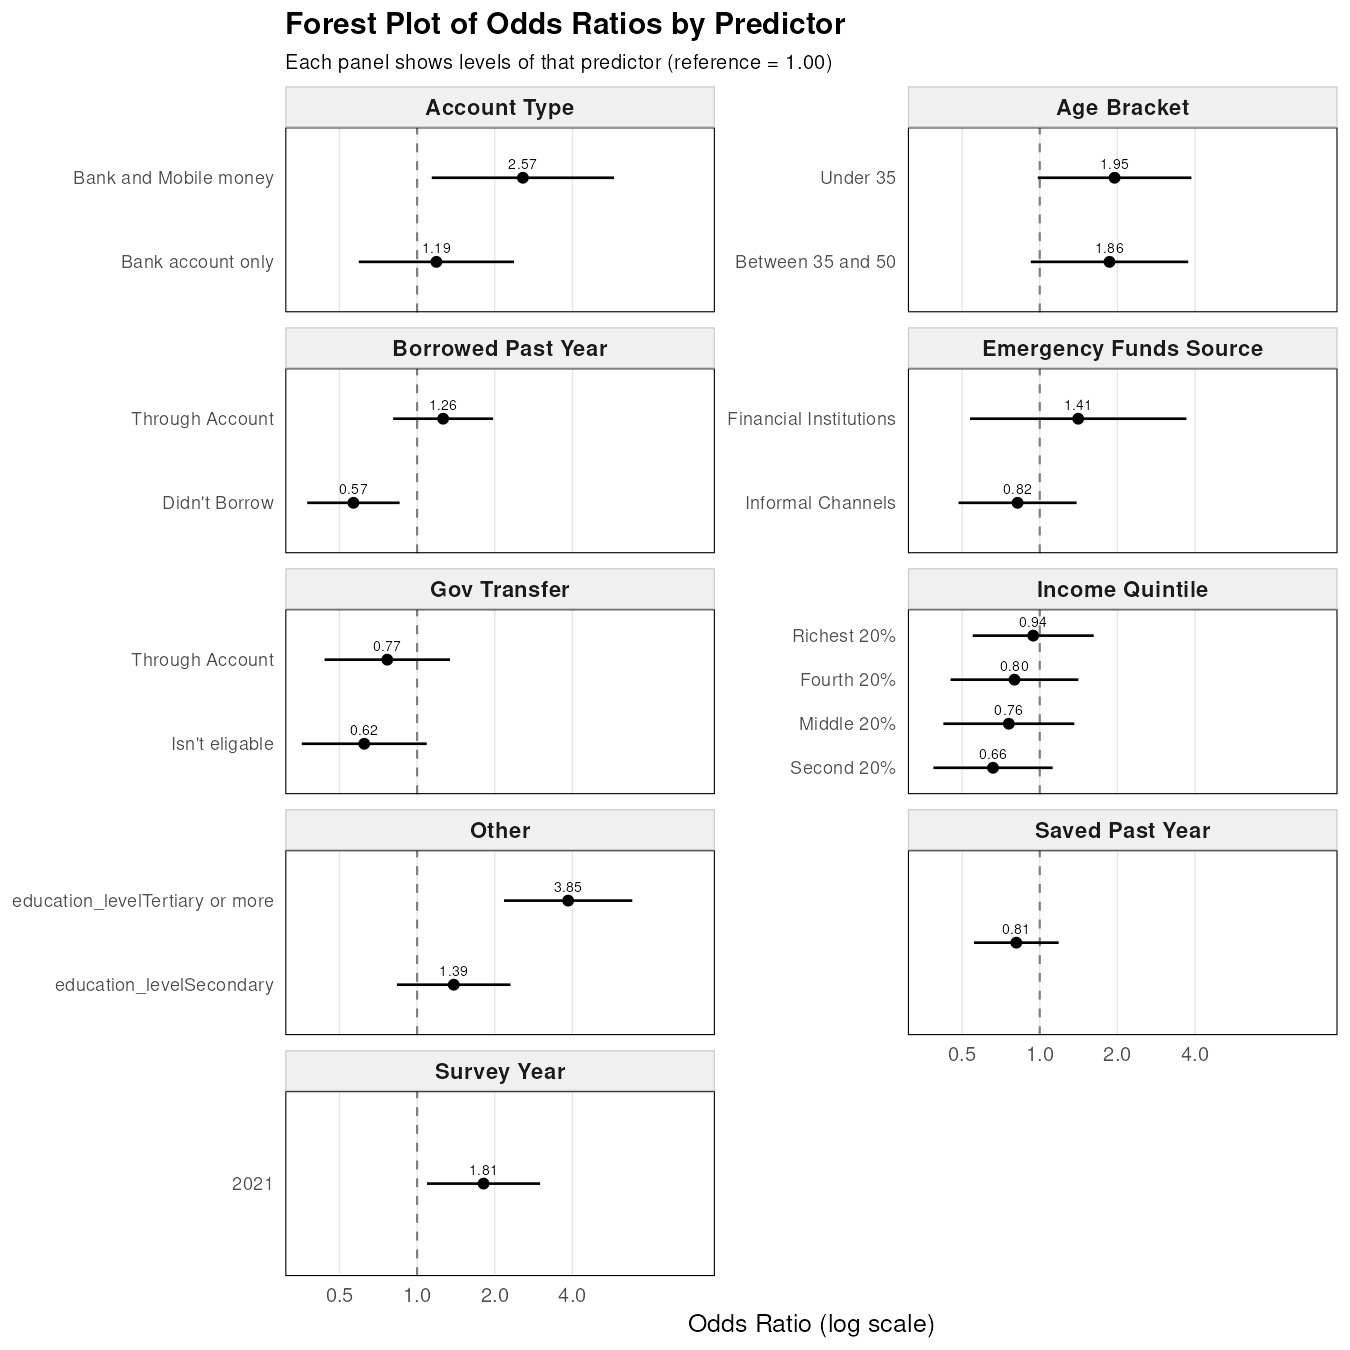

In [230]:
# 1a) Tidy up the model output, compute ORs and CIs, and create a grouping variable
or_data <- broom::tidy(model) |>
  filter(term != "(Intercept)") |>
  mutate(
    OR       = exp(estimate),
    CI_low   = exp(estimate - 1.96 * std.error),
    CI_high  = exp(estimate + 1.96 * std.error),
    # assign each term to a “human‐readable” predictor group
    predictor = case_when(
      str_detect(term, "^survay_year")                   ~ "Survey Year",
      str_detect(term, "^received_government_transfer")  ~ "Gov Transfer",
      str_detect(term, "^educaton_level")                ~ "Education",
      str_detect(term, "^age_bracket")                   ~ "Age Bracket",
      str_detect(term, "^hh_income_quintile")            ~ "Income Quintile",
      str_detect(term, "^main_source_of_emergency_funds")~ "Emergency Funds Source",
      str_detect(term, "^saved_in_past_year")            ~ "Saved Past Year",
      str_detect(term, "^borrowed_in_past_year")         ~ "Borrowed Past Year",
      str_detect(term, "^account")                       ~ "Account Type",
      TRUE                                               ~ "Other"
    ),
    # extract just the level label (everything after the prefix)
    level = case_when(
      predictor == "Survey Year"               ~ str_replace(term, "survay_year", ""),
      predictor == "Gov Transfer"              ~ str_replace(term, "received_government_transfer", ""),
      predictor == "Education"                 ~ str_replace(term, "educaton_level", ""),
      predictor == "Age Bracket"               ~ str_replace(term, "age_bracket", ""),
      predictor == "Income Quintile"           ~ str_replace(term, "hh_income_quintile", ""),
      predictor == "Emergency Funds Source"    ~ str_replace(term, "main_source_of_emergency_funds", ""),
      predictor == "Saved Past Year"           ~ str_replace(term, "saved_in_past_year", ""),
      predictor == "Borrowed Past Year"        ~ str_replace(term, "borrowed_in_past_year", ""),
      predictor == "Account Type"              ~ str_replace(term, "account", ""),
      TRUE                                      ~ term
    ) |>
      str_trim()
  )
# -------------------------------------------------------------------
# 1b) Polished Forest‐Style Plot with OR Labels, Borders, and Tidy Grid
# -------------------------------------------------------------------

forest_plot <- or_data |>
  ggplot(aes(x = OR, y = fct_reorder(level, OR))) +
  # Reference line at OR = 1
  geom_vline(xintercept = 1, lty = 2, color = "gray50") +
  # Points with CIs
  geom_pointrange(
    aes(xmin = CI_low, xmax = CI_high),
    shape = 16, linewidth = 0.6, color = "black"
  ) +
  # Odds‐ratio labels above each point
  geom_text(
    aes(label = sprintf("%.2f", OR)),
    color = "black",
    size = 2.5,
    vjust = -0.8
  ) +
  # Facet by predictor, two columns
  facet_wrap(~ predictor, scales = "free_y", ncol = 2) +
  # Expand x‐axis a bit so labels don't get cut off
  scale_x_log10(
    name = "Odds Ratio (log scale)",
    breaks = c(0.25, 0.5, 1, 2, 4),
    labels = scales::comma_format(accuracy = 0.1),
    expand = expansion(mult = c(0.05, 0.25))
  ) +
  labs(
    y = NULL,
    title = "Forest Plot of Odds Ratios by Predictor",
    subtitle = "Each panel shows levels of that predictor (reference = 1.00)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    # Panel border around each facet
    panel.border       = element_rect(color = "black", fill = NA, linewidth = 0.5),
    # Tidy up grid lines: major lines light gray, remove minor
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_line(color = "gray90", linewidth = 0.3),
    panel.grid.minor   = element_blank(),
    # Strip labels formatting
    strip.background   = element_rect(fill = "#f0f0f0", color = "gray80"),
    strip.text         = element_text(face = "bold", size = 11),
    # Y‐axis text size
    axis.text.y        = element_text(size = 9),
    # Title formatting
    plot.title         = element_text(face = "bold"),
    plot.subtitle      = element_text(size = 10),
    # Remove extra spacing between facets
    strip.placement    = "outside",
    panel.spacing.y    = unit(0.5, "lines"),
    panel.background = element_rect(fill = "white", colour = NA),
    plot.background  = element_rect(fill = "white", colour = NA)
  )

# Print the polished forest plot
forest_plot |> fig(9,9,"model_forest_plot")


Saved plot to: /workspaces/diba/figures/model_account_year.png



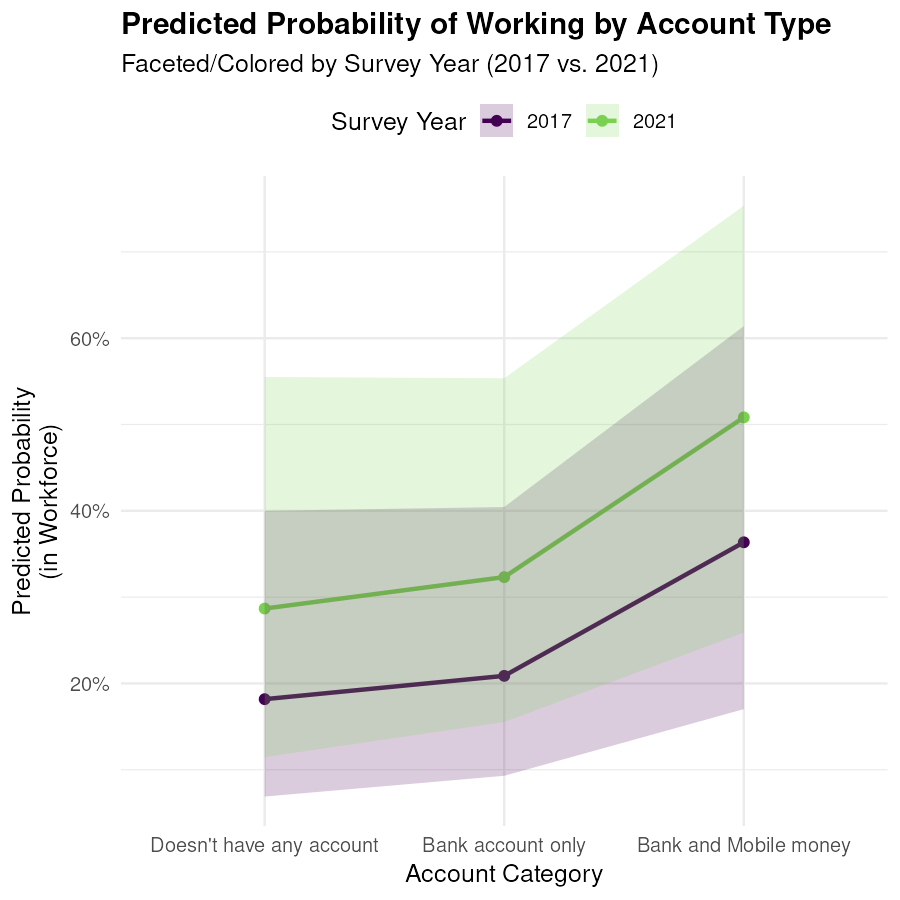

In [231]:
# 2. Predicted Probability by Account Type × Survey Year

pp_account_year <- ggeffects::ggpredict(
  model,
  terms = c("account", "survay_year"),
  type = "fixed"
) |>
  # ensure x (account levels) stays in the intended order:
  mutate(x = factor(x, levels = unique(x)))

prob_account_year_plot <- pp_account_year |>
  ggplot(aes(
    x = x,
    y = predicted,
    color = group,
    fill = group,
    group = group
  )) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high), alpha = 0.2, color = NA) +
  scale_y_continuous(
    name = "Predicted Probability\n(in Workforce)",
    labels = scales::percent_format(accuracy = 1)
  ) +
  scale_x_discrete(name = "Account Category") +
  scale_color_viridis_d(option = "D", end = 0.8, name = "Survey Year") +
  scale_fill_viridis_d(option = "D", end = 0.8, name = "Survey Year") +
  labs(
    title = "Predicted Probability of Working by Account Type",
    subtitle = "Faceted/Colored by Survey Year (2017 vs. 2021)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "top",
    plot.title = element_text(face = "bold"),
    panel.background = element_rect(fill = "white", colour = NA),
    plot.background  = element_rect(fill = "white", colour = NA)
  )

# Print it
prob_account_year_plot |> fig(6,6,"model_account_year")


Saved plot to: /workspaces/diba/figures/model_predicted_participatio.png



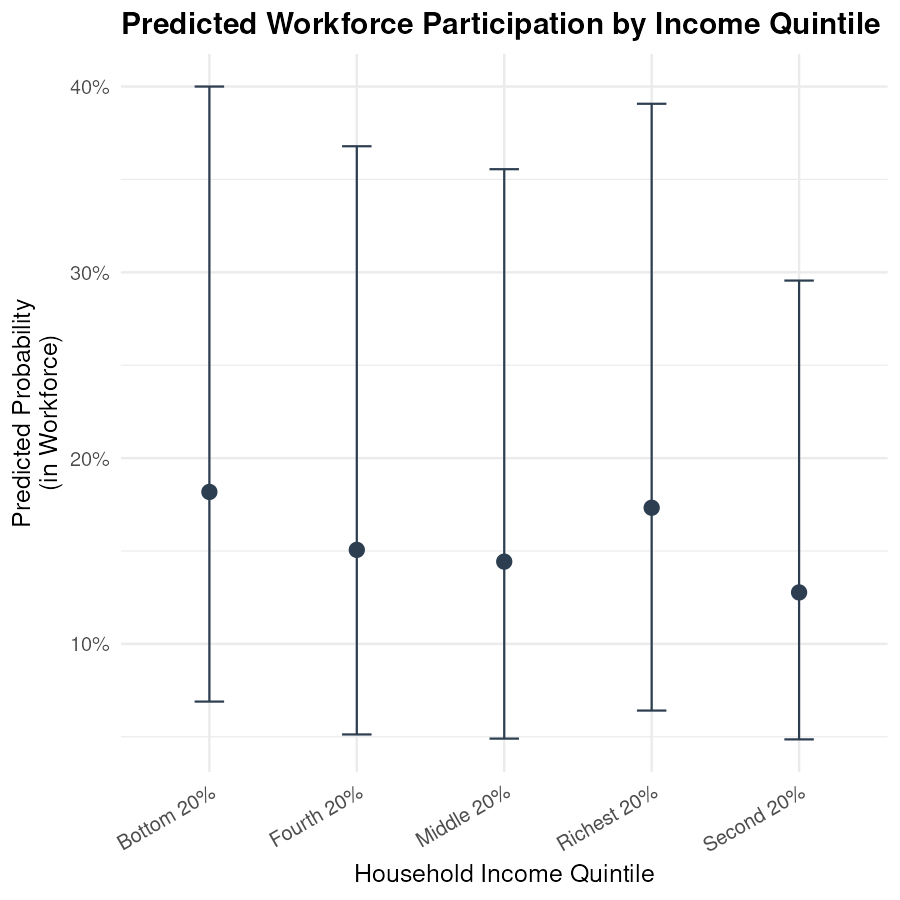

In [232]:
# 4a) Get predicted probabilities for "hh_income_quintile"
pp_income <- ggeffects::ggpredict(
  model,
  terms = "hh_income_quintile",
  type = "fixed"
)

# 4b) Simple bar‐style / point‐and‐error‐bar plot of predicted probabilities
prob_income_plot <- pp_income |>
  ggplot(aes(x = x, y = predicted)) +
  geom_point(size = 3, color = "#2c3e50") +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2, color = "#2c3e50") +
  scale_y_continuous(
    name = "Predicted Probability\n(in Workforce)",
    labels = scales::percent_format(accuracy = 1)
  ) +
  scale_x_discrete(name = "Household Income Quintile") +
  labs(
    title = "Predicted Workforce Participation by Income Quintile"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 30, hjust = 1),
    plot.title = element_text(face = "bold"),
    panel.background = element_rect(fill = "white", colour = NA),
    plot.background  = element_rect(fill = "white", colour = NA)
  )

# Print it
prob_income_plot |> fig(6,6,"model_predicted_participatio")


Saved plot to: /workspaces/diba/figures/model_mpp.png



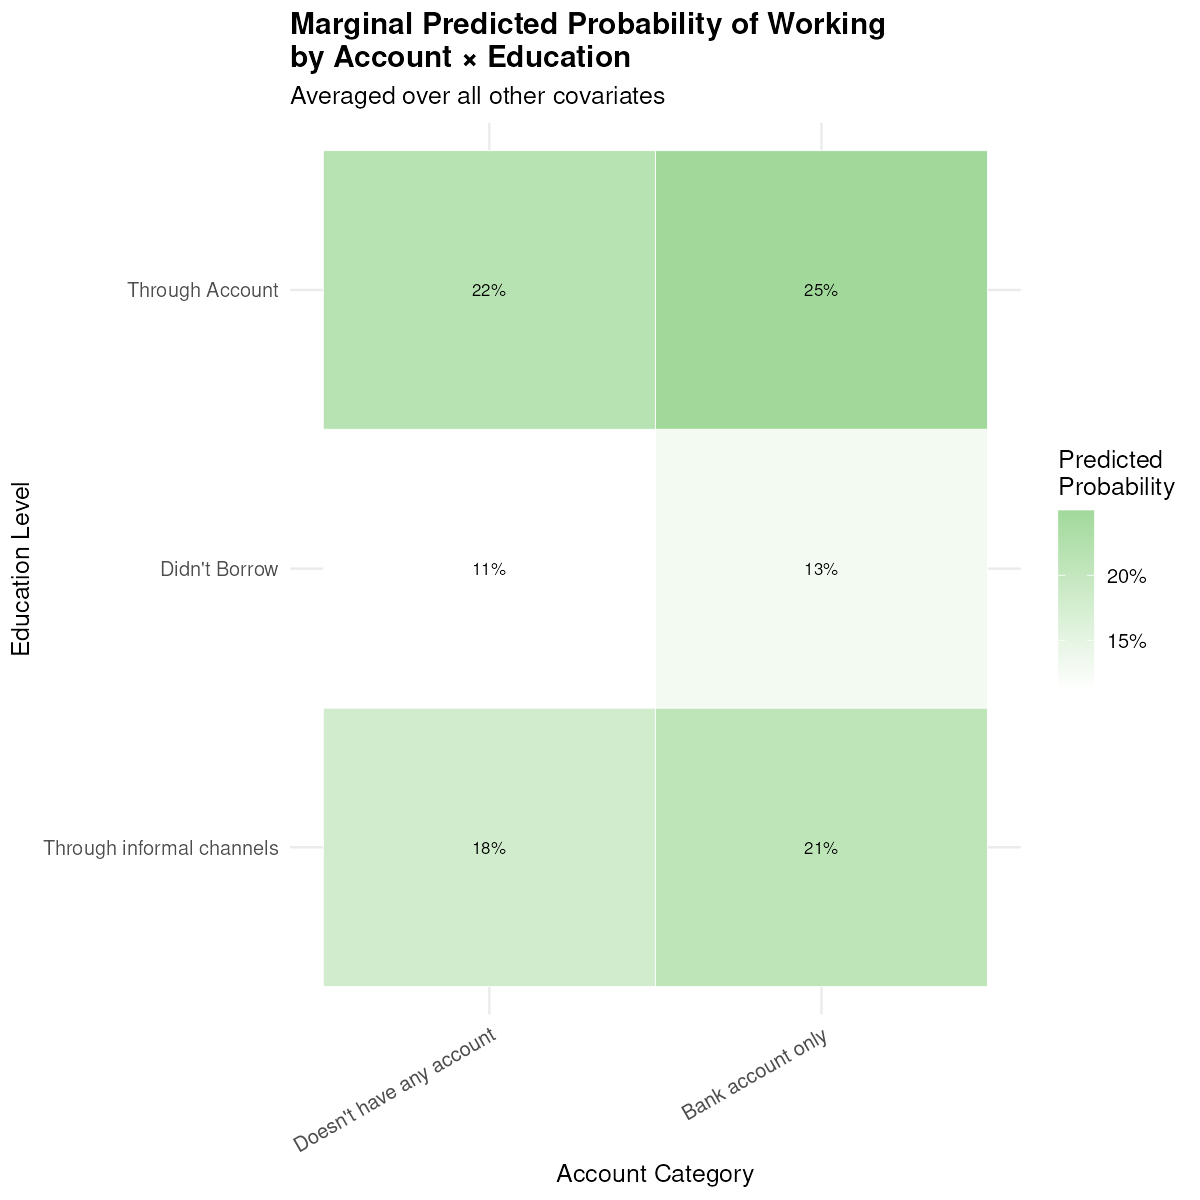

In [233]:
# -------------------------------------------------------------------
# Heatmap of Predicted Probability: Account Type × Education Level
# (White → Light Green Colorblind‐Friendly Gradient)
# -------------------------------------------------------------------

# 1) Use ggpredict() to get marginal predictions for each combination
heatmap_df <- ggeffects::ggpredict(
  model,
  terms = c("account", "borrowed_in_past_year"),
  type  = "fixed"
) |>
  rename(
    account         = x,
    education_level = group,
    prob             = predicted,
    lower            = conf.low,
    upper            = conf.high
  ) |>
  mutate(
    account         = factor(account, levels = unique(account)),
    education_level = factor(education_level, levels = unique(education_level))
  )

# 2) Plot a tile (geom_tile) where x = Account, y = Education, fill = Predicted Prob.
heatmap_plot <- heatmap_df |>
  ggplot(aes(
    x    = account,
    y    = education_level,
    fill = prob
  )) +
  geom_tile(color = "white", size = 0.2) +
  geom_text(aes(label = scales::percent(prob, accuracy = 1)), size = 3) +
  scale_fill_gradient(
    name   = "Predicted\nProbability",
    low    = "white",
    high   = "#a1d99b",
    labels = scales::percent_format(accuracy = 1)
  ) +
  labs(
    x        = "Account Category",
    y        = "Education Level",
    title    = "Marginal Predicted Probability of Working\nby Account × Education",
    subtitle = "Averaged over all other covariates"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.x  = element_text(angle = 30, hjust = 1),
    plot.title   = element_text(face = "bold"),
    axis.title.y = element_text(vjust = 1.2),
    panel.background = element_rect(fill = "white", colour = NA),
    plot.background  = element_rect(fill = "white", colour = NA)
  )

# 3) Print the heatmap
heatmap_plot |> fig(8,8,"model_mpp")


# Robustness checks

## 1. Robust to observation weights

### 1.1 Outlier cuttoff

**Explanation**: 
1. find the distribution of weights given by `observaton_weights` variable.
2. cutt the extreme 2.5% from both sides (so you've left with 95% in the middle).
3. compute the model again.
4. compare the difference between the two.

In [234]:
gfi_trimmed <- gfi_wrangled |>
  mutate(
    weight_cutoff = observation_weight |> quantile(probs = 0.95),
    trimmed_wt = pmin(observation_weight, weight_cutoff)
  )


# 3) Redefine survey design using trimmed weights
design_trim <- svydesign(
  ids = ~1,
  weights = ~trimmed_wt,
  data = gfi_trimmed
)

# 4) Re‐run the same quasibinomial model on the trimmed‐weight design
model_trim <- svyglm(
  form,
  design = design_trim,
  family = quasibinomial()
)

print_multi_mathjax_table(
  list(
    get_tidy(model,design,form,pval = TRUE),
    get_tidy(model_trim,design_trim,form,pval = TRUE)
  ),
  c("Logit","Trimmed Logit"),
  title = "Table 2. Outlier Cuttoff Test"
) |> IRdisplay::display_latex()

## 2. Robust to regression form

### 3.1 Linear Probability instead of Logit

**Explanation**: what would change if we estimated the model using a simple regression on probabilities instead of Logit, would results differ much?

In [235]:
# 2) Fit an LPM by using family = gaussian() with the same formula
model_lpm <- svyglm(
  form,
  design = design,
  family = gaussian()
)

### 3.2 Probit instead of Logit

**Explanation**: what would happen if we estimated the model via probit method instead of logit, would result differ much?

In [236]:
model_probit <- svyglm(
  form,
  design = design,
  family = quasibinomial(link = "probit")
)

In [237]:
print_multi_mathjax_table(
  list(
    get_tidy(model,design,form,pval = TRUE),
    get_tidy(model_probit,design,form,pval = TRUE),
    get_tidy(model_lpm,design,form,pval = TRUE)
  ),
  c("Logit","Probit","LPM"),
  title = "Table 3. Comparing Various Functional Forms"
) |> IRdisplay::display_latex()

Saved plot to: /workspaces/diba/figures/comparison.png



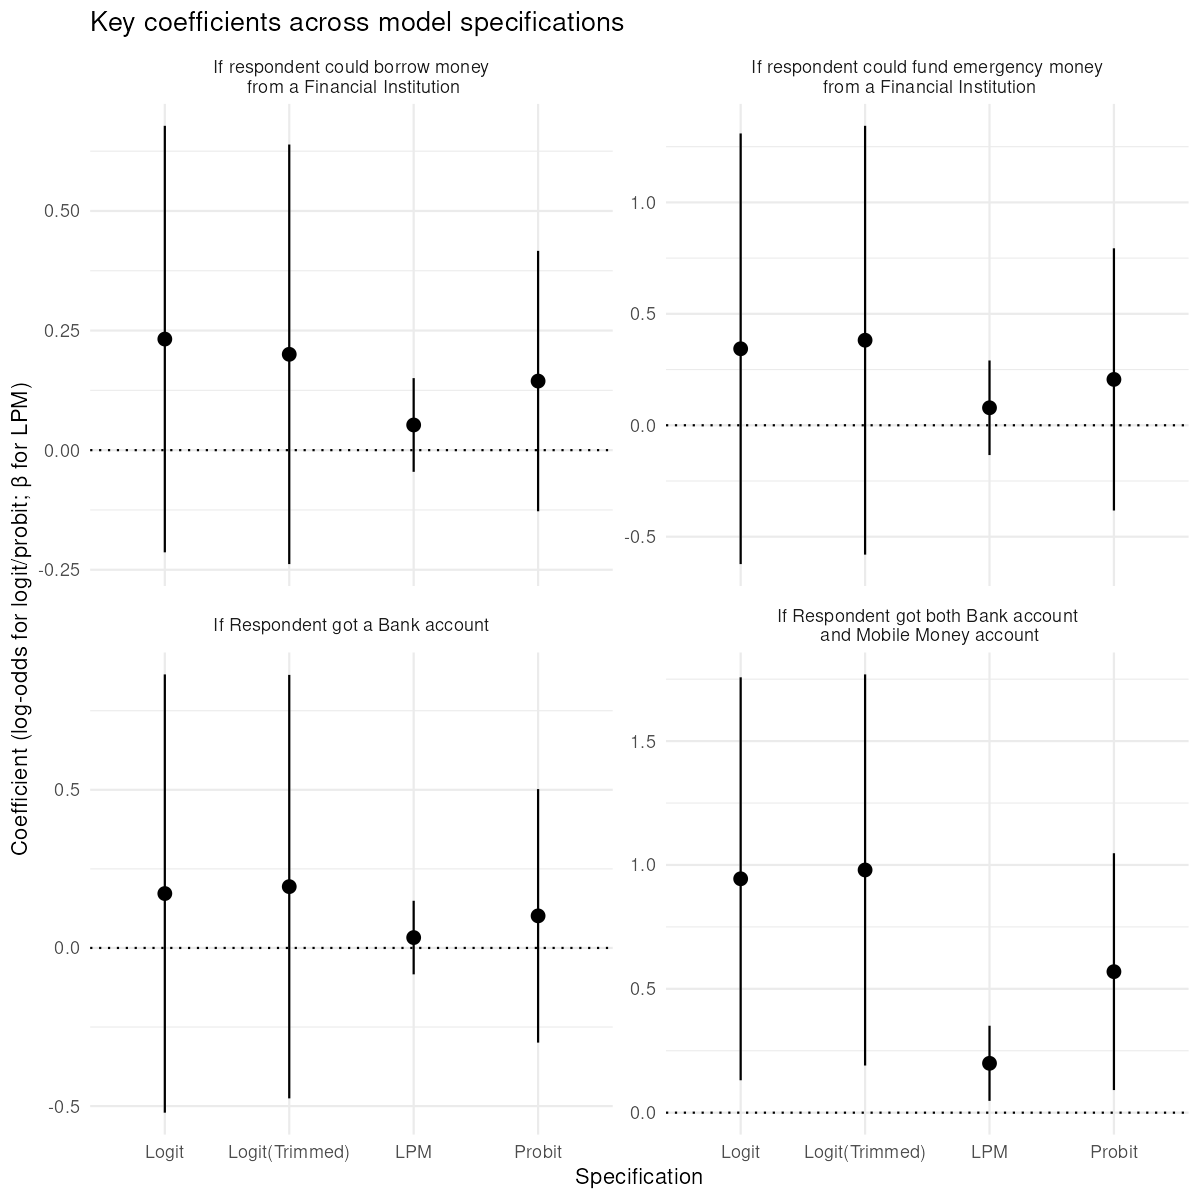

In [238]:
## Gather coefficients from all four models
coef_tbl <- list(
  Logit = model,
  `Logit(Trimmed)` = model_trim,
  LPM = model_lpm,
  Probit = model_probit
) |>
  imap_dfr(~ tidy(.x) |>
    filter(term %in% c(
      "accountBank account only",
      "accountBank and Mobile money",
      "borrowed_in_past_yearThrough Account",
      "main_source_of_emergency_fundsFinancial Institutions"
    )) |>
    mutate(model = .y)) |>
  mutate(
    term = recode(term,
      "accountBank account only" = "If Respondent got a Bank account",
      "accountBank and Mobile money" = "If Respondent got both Bank account\n and Mobile Money account",
      "borrowed_in_past_yearThrough Account" = "If respondent could borrow money\n from a Financial Institution",
      "main_source_of_emergency_fundsFinancial Institutions" = "If respondent could fund emergency money\n from a Financial Institution"
    ),
    ymin = estimate - 1.96 * std.error,
    ymax = estimate + 1.96 * std.error
  )

## Plot
comparison_plot <- ggplot(
  coef_tbl,
  aes(
    x = model, y = estimate,
    ymin = ymin, ymax = ymax
  )
) +
  geom_pointrange() +
  facet_wrap(~term, scales = "free_y") +
  geom_hline(yintercept = 0, linetype = "dotted") +
  labs(
    title = "Key coefficients across model specifications",
    x = "Specification",
    y = "Coefficient (log-odds for logit/probit; β for LPM)"
  ) +
  theme_minimal(base_size = 11) +
  theme(
    panel.background = element_rect(fill = "white", colour = NA),
    plot.background = element_rect(fill = "white", colour = NA)
  )

fig(comparison_plot, 8, 8, "comparison")


## 3. Robust to omitted variables (problematic)

### 3.1 Oster delta

*citation*
- Oster, E. (2017). Unobservable Selection and Coefficient Stability: Theory and Evidence.
Journal of Business & Economic Statistics, 37(2), 187–204. https://doi.org/10.1080/07350015.2016.1227711

In [239]:
calc_delta <- function(var_name, Y, X, design, model_lpm) {
  lpm_simple <- svyglm(
    formula = as.formula(paste0(Y, " ~ ", X)),
    design = design,
    family = gaussian()
  )
  # 1. Extract coefficient for the supplied variable from both models
  beta_R <- coef(lpm_simple)[var_name]
  beta_F <- coef(model_lpm)[var_name]

  # 2. Compute R² for restricted and full models
  R2_R <- 1 - deviance(lpm_simple) / lpm_simple$null.deviance
  R2_F <- 1 - deviance(model_lpm) / model_lpm$null.deviance

  # 3. Define the caps you want to try
  caps <- c(0.8)

  # 4. Build a tibble of (cap, δ)
  tibble(cap = caps) |>
    mutate(
      R_max = pmin(cap, 1.3 * R2_F),
      delta = ((beta_F - beta_R) / beta_F) *
        ((R_max - R2_F) / (R2_F - R2_R))
    ) |>
    select(cap, delta) |>
    mutate(varname = sub(paste0("^", X), paste0(X, " : "), var_name))
}

c(
  "survay_year2021",
  "received_government_transferIsn't eligable",
  "received_government_transferThrough Account",
  "education_levelSecondary",
  "education_levelTertiary or more",
  "age_bracketBetween 35 and 50",
  "age_bracketUnder 35",
  "hh_income_quintileFourth 20%",
  "hh_income_quintileMiddle 20%",
  "hh_income_quintileRichest 20%",
  "hh_income_quintileSecond 20%",
  "main_source_of_emergency_fundsFinancial Institutions",
  "main_source_of_emergency_fundsInformal Channels",
  "saved_in_past_year",
  "borrowed_in_past_yearDidn't Borrow",
  "borrowed_in_past_yearThrough Account",
  "accountBank account only",
  "accountBank and Mobile money"
) |>
  map2_df(
    c(
      "survay_year",
      "received_government_transfer",
      "received_government_transfer",
      "education_level",
      "education_level",
      "age_bracket",
      "age_bracket",
      "hh_income_quintile",
      "hh_income_quintile",
      "hh_income_quintile",
      "hh_income_quintile",
      "main_source_of_emergency_funds",
      "main_source_of_emergency_funds",
      "saved_in_past_year",
      "borrowed_in_past_year",
      "borrowed_in_past_year",
      "account",
      "account"
    ),
    ~ calc_delta(.x, "in_workforce", .y, design, model_lpm)
  ) |>
  pivot_wider(names_from = "cap", values_from = "delta")


varname,0.8
<chr>,<dbl>
survay_year : 2021,0.14948089
received_government_transfer : Isn't eligable,0.05564132
received_government_transfer : Through Account,0.17854064
education_level : Secondary,-0.16259224
education_level : Tertiary or more,-0.11418813
age_bracket : Between 35 and 50,-0.14835909
age_bracket : Under 35,-0.16599123
hh_income_quintile : Fourth 20%,0.13740341
hh_income_quintile : Middle 20%,0.13485885


### 3.2 Leave one out test (LOO)

**Explanation**:
1. it omits one of the variables and reruns the model, calculates the estimates.
2. it does this for all variables
3. I've done this procedure for the four key variables `borrowed_in_past_yearThrough Account`,`accountBank and Mobile money`,
`accountBank account only`

In [240]:
# vector of predictor names (excluding intercept)
preds <- attr(terms(form), "term.labels")

# helper: run glm after dropping one variable
drop_run <- function(drop_var, X) {
  ff <- reformulate(
    setdiff(preds, drop_var),
    response = "in_workforce"
  )
  fit <- svyglm(ff, design = design, family = quasibinomial())
  coefs <- coef(fit)[X]
  tibble(
    dropped = drop_var,
    !!X := coefs[1],
  )
}

pblapply(preds, drop_run, "borrowed_in_past_yearThrough Account") |>
  bind_rows() |>
  left_join(
    pblapply(preds, drop_run, "accountBank account only") |> bind_rows(),
    by = "dropped"
  ) |>
  left_join(
    pblapply(preds, drop_run, "accountBank and Mobile money") |> bind_rows(),
    by = "dropped"
  ) |>
  left_join(
    pblapply(preds, drop_run, "received_government_transferThrough Account") |> bind_rows(),
    by = "dropped"
  )


dropped,borrowed_in_past_yearThrough Account,accountBank account only,accountBank and Mobile money,received_government_transferThrough Account
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
survay_year,0.2132393,0.1795996,0.8398344,-0.3564340
received_government_transfer,0.2439241,0.2612033,1.0444121,NA
education_level,0.3884422,0.4008528,1.2520749,-0.2320058
age_bracket,0.2127754,0.1623759,0.9270921,-0.2505431
hh_income_quintile,0.2337843,0.2213857,0.9752937,-0.2410607
main_source_of_emergency_funds,0.2466209,0.1728097,0.9281042,-0.2520511
saved_in_past_year,0.2219714,0.1385060,0.8634137,-0.2482565
borrowed_in_past_year,NA,0.3117052,1.1174512,-0.2186970
account,0.2359192,NA,NA,-0.1909702


Saved plot to: /workspaces/diba/figures/LOO_plot.png



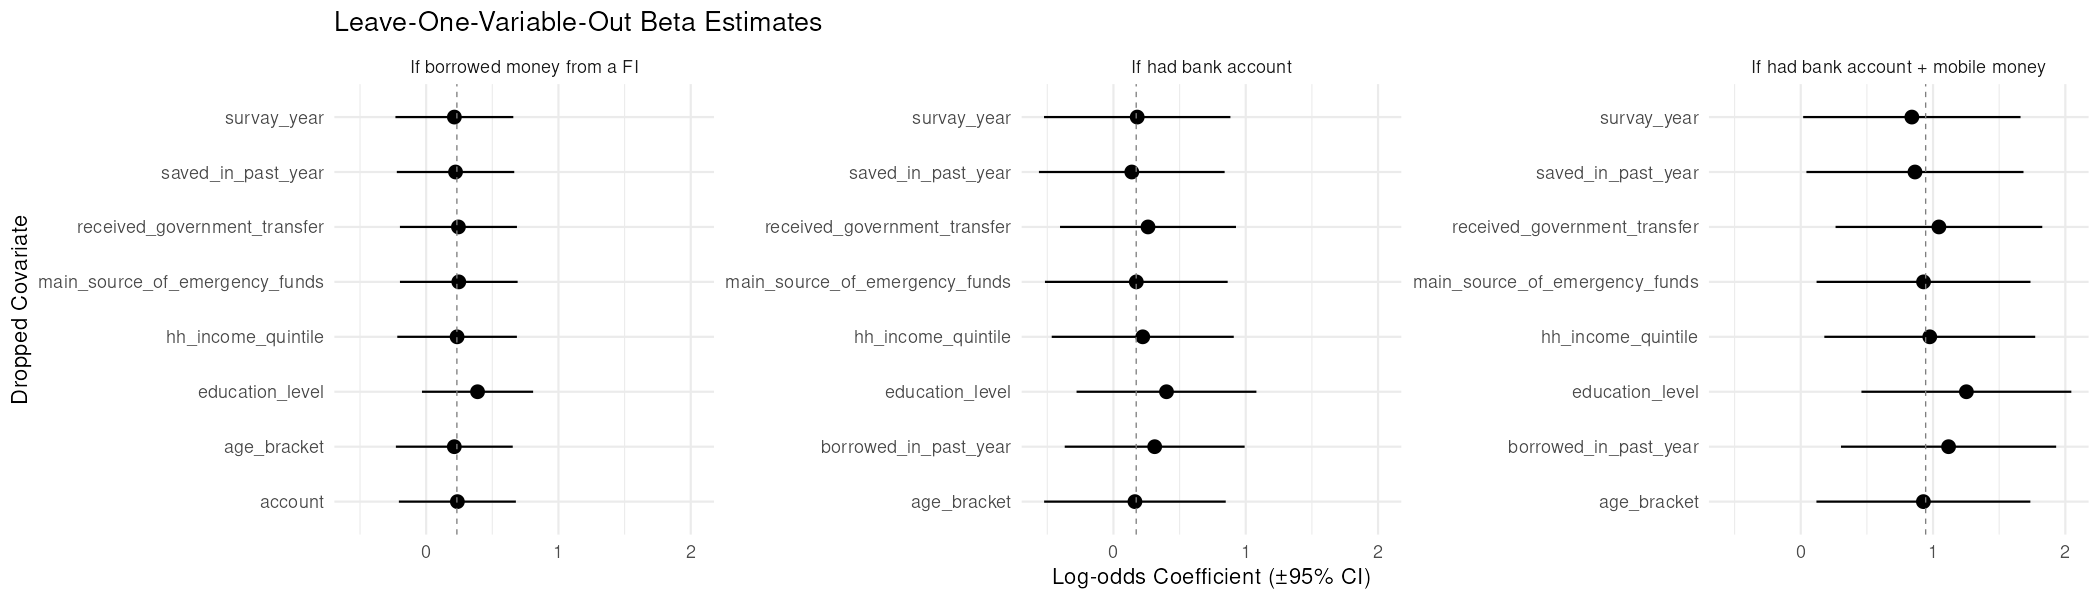

In [241]:
# 0. Define reference terms
ref_terms <- c(
  "borrowed_in_past_yearThrough Account",
  "accountBank and Mobile money",
  "accountBank account only"
)

# 1. Pull those coefficients from the full model
beta_ref <- tidy(model) |>
  filter(term %in% ref_terms) |>
  select(term, estimate) |>
  deframe()

# 2. Vector of all RHS terms in the full model
preds <- attr(terms(model), "term.labels")

# 3. Function: fit model dropping one variable, return est & SE for focal terms
drop_run <- function(drop_var) {
  form2 <- reformulate(setdiff(preds, drop_var), response = "in_workforce")
  fit <- svyglm(form2, design = design, family = quasibinomial())
  tidy(fit) |>
    filter(term %in% ref_terms) |>
    mutate(dropped = drop_var) |>
    select(dropped, term, estimate, std.error)
}

# 4. Run over all predictors
loo_tbl <- pblapply(preds, drop_run) |>
  bind_rows()

# 5. Prep for plotting: recode labels, compute 95% CIs
label_map <- c(
  "borrowed_in_past_yearThrough Account" = "If borrowed money from a FI",
  "accountBank account only"               = "If had bank account",
  "accountBank and Mobile money"           = "If had bank account + mobile money"
)

loo_plot_data <- loo_tbl |>
  mutate(
    term = recode(term, !!!label_map),
    ymin = estimate - 1.96 * std.error,
    ymax = estimate + 1.96 * std.error
  )

# 6. Put beta_ref into a tibble with the same labels
beta_ref_df <- tibble(
  term     = names(beta_ref),
  baseline = as.numeric(beta_ref)
) |>
  mutate(term = recode(term, !!!label_map))

# 7. Faceted plot
loo_plot <- ggplot(
  loo_plot_data,
  aes(x = dropped, y = estimate, ymin = ymin, ymax = ymax)
) +
  geom_pointrange() +
  geom_hline(
    data      = beta_ref_df,
    aes(yintercept = baseline),
    linetype  = "dashed",
    colour    = "grey50",
    linewidth = 0.3
  ) +
  facet_wrap(~ term, scales = "free_y") +
  coord_flip() +
  labs(
    title = "Leave-One-Variable-Out Beta Estimates",
    x     = "Dropped Covariate",
    y     = "Log-odds Coefficient (±95% CI)"
  ) +
  theme_minimal(base_size = 11) +
  theme(legend.position = "none",
            panel.background = element_rect(fill = "white", colour = NA),
    plot.background  = element_rect(fill = "white", colour = NA))

fig(loo_plot,14,4,"LOO_plot")

## 4. Robust to parametric form

### 4.1 Bootstrap

In [242]:
# 2. Convert to a 1000-replicate bootstrap design
set.seed(123) # for reproducibility
design_rep <- as.svrepdesign(
  design,
  type       = "bootstrap",
  replicates = 1e3
)

model_rep <- svyglm(
  form,
  design = design_rep,
  family = quasibinomial()
)

print_multi_mathjax_table(
  list(
    get_tidy(model,design,form,pval = TRUE),
    get_tidy(model_rep,design_rep,form,pval = TRUE)
  ),
  c("Model","Bootstrapped"),
  title = "Table 4.Bootstrap Results",
  subtitle = " 1000 Replications "
) |> IRdisplay::display_latex()

## 5. Heterogeneity check

### 5.1 Only transfer-eligable women

In [243]:
gfi_trnsf <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 0, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c), # 11 observations, I will gamble and omit this also.
    received_government_transfers_c != 0
  ) |>
  clean() |>
  select(-all_of(excl_vars)) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor(collapse=TRUE)



design_trnsf <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_trnsf)
model_trnsf <- svyglm(
  form,
  design = design_trnsf,
  family = quasibinomial()
)

### 5.2 Only Borrowers

In [244]:
gfi_brw <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 0, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c), # 11 observations, I will gamble and omit this also.
    borrowed_in_the_past_year_c != 0
  ) |>
  clean() |>
  select(-all_of(excl_vars)) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor()

design_brw <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_brw)
model_brw <- svyglm(
  form,
  design = design_brw,
  family = quasibinomial()
)

### 5.3 Only Non-savers

In [245]:
gfi_save <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 0, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c), # 11 observations, I will gamble and omit this also.
    saved_in_past_year_b != 0
  ) |>
  clean() |>
  select(-all_of(excl_vars)) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor()

design_save <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_save)
form_save <- in_workforce ~ survay_year + received_government_transfer + education_level +
  age_bracket + hh_income_quintile + main_source_of_emergency_funds +
  borrowed_in_past_year + account

model_save <- svyglm(
  form_save,
  design = design_save,
  family = quasibinomial()
)


In [246]:
print_multi_mathjax_table(
  list(
    get_tidy(model,design,form,pval = TRUE),
    get_tidy(model_trnsf,design_trnsf,form,pval = TRUE),
    get_tidy(model_brw,design_brw,form,pval = TRUE),
    get_tidy(model_save,design_save,form_save,pval = TRUE)
  ),
  c("Full sample","Transfer Eligables","Borrowes","Savers"),
  title = "Table 5. Subsampling Results"
) |> IRdisplay::display_latex()

Warning message:
“There was 1 warning in `arrange()`.
ℹ In argument: `..1 = fct_relevel(...)`.
Caused by warning:
! 4 unknown levels in `f`: Income Quintile: Second 20%, Income Quintile: Middle
20%, Income Quintile: Fourth 20%, and Income Quintile: Richest 20%”


## 6. Placebo

### 6.1 Only Pension receivers

In [247]:
gfi_pens <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 1, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c) # 11 observations, I will gamble and omit this also.
  ) |>
  clean() |>
  select(-all_of(excl_vars)) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor(ref="Bank account only")


design_pens <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_pens)
model_pens <- svyglm(
  form,
  design = design_pens,
  family = quasibinomial()
)

print_multi_mathjax_table(
  list(
    get_tidy(model,design,form,pval = TRUE),
    get_tidy(model_pens,design_pesn,form,pval = TRUE)
  ),
  c("Full sample","Only Pensioners"),
  title = "Table 6. Placebo Test"
) |> IRdisplay::display_latex()

## 7. Specification check

In [248]:
gfi_sp <- gfi_tbl |>
  filter(
    respondent_age_o >= 15, # working age
    respondent_age_o <= 65, # excluding elderly
    received_government_pension_b == 0, # exluding retires, this variables has only 1 NA.
    !is.na(borrowed_in_the_past_year_c), # only three observations, I think it's safe to omit.
    !is.na(main_source_emergency_funds_c) # 11 observations, I will gamble and omit this also.
  ) |>
clean() |>
  select(-c(
    # irrelevant
    id_i,

    # institutional FI
    has_account_b,
    has_financial_institution_account_b,
    reason_no_account_c,
    has_mobile_money_account_b,

    # redundancy to in_the_workforce_b
    received_government_pension_b,
    received_government_pension_payment_c,

    # digital FI
    #made_or_received_digital_payment_b,
    used_phone_for_finance_b,
    # owns_mobile_phone_b,
    any_deposit_into_account_b,
    any_withdrawal_from_account_b,

    # withouth any meaningful impact
    any_deposit_into_account_b,
    any_withdrawal_from_account_b,
    respondent_age_o
  )) |>
  drop_na() |>
  rename(!!!new_names) |>
  refactor()

### 7.1 specific to digital payments

In [249]:
design_dig <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_sp)
form_dig <- in_workforce ~ survay_year + received_government_transfer + education_level +
  age_bracket + hh_income_quintile + main_source_of_emergency_funds +
  saved_in_past_year + borrowed_in_past_year  + account + made_or_received_digital_payment_b

model_dig <- svyglm(
  form_dig,
  design = design_dig,
  family = quasibinomial()
)

### 7.2 specific to owning a mobile phone

In [250]:
design_phone <- svydesign(ids = ~1, weights = ~observation_weight, data = gfi_sp)
form_phone <- in_workforce ~ survay_year + received_government_transfer + education_level +
  age_bracket + hh_income_quintile + main_source_of_emergency_funds +
  saved_in_past_year + borrowed_in_past_year + owns_mobile_phone_b + account

model_phone <- svyglm(
  form_phone,
  design = design_phone,
  family = quasibinomial()
)

In [251]:
print_multi_mathjax_table(
  list(
    get_tidy(model,design,form,pval = TRUE),
    get_tidy(model_dig,design_dig,form_dig,pval = TRUE),
    get_tidy(model_phone,design_phone,form_phone,pval = TRUE)
  ),
  c("Reference Model","Digital Payments","Owning a Phone"),
  title = "Table 7. Specificification Test",
  footnote = ". note that receiving digital payments has near perfect colinearity, thus it's not shown in the results"
) |> IRdisplay::display_latex()